In [12]:
# from https://github.com/HANTLUK/PauliDecomposition
import sys
sys.path.append("..")

import numpy as np
from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt
import time
import csv

from ThirdParty.TensorizedPauliDecomposition import PauliDecomposition
import Code.LSSVM as LSSVM
from Code.VQLSSVM import VQLSSVM
from Code.Utils import prepareDataset

In [13]:
def sparsePauliOeratorLCU(matrix):
	testResult2 = SparsePauliOp.from_operator(matrix)
	coeffs2 = testResult2.coeffs
	list2 = testResult2.paulis
	return [list2,coeffs2]

def tensorizedPauliDecompositionLCU(matrix):
	return PauliDecomposition(matrix)

def randomMatrix(dim):
	return np.add(np.random.rand(dim,dim),1.j*np.random.rand(dim,dim))

def comparison(method1, method2, matrix):
	start = time.time()
	list1,coeffs1 = method1(matrix)
	end = time.time()
	method1Time = end-start
	print (method1.__name__,"time:",method1Time, "coefLen", len(coeffs1))
	start = time.time()
	list2,coeffs2 = method2(matrix)
	end = time.time()
	method2Time = end-start
	print (method2.__name__,"time:",method2Time, "coefLen", len(coeffs2))
	equal = True
	for x,y in zip(list1,list2):
		if str(x) != str(y):
			equal = False
	eps = 10**(-5)
	for x,y in zip(coeffs1,coeffs2):
		if abs(complex(x) - complex(y)) > eps:
			equal = False
	return equal, method1Time, method2Time

In [14]:
tpdTimes, sparsePauliOpTimes = [],[]
qubits = 8

for i in range (1,qubits+1):
    print("qubits: ",i)
    testMatrix = randomMatrix(2**i)
    equal, method1, method2 = comparison(tensorizedPauliDecompositionLCU,sparsePauliOeratorLCU,testMatrix)
    print(equal)
    tpdTimes.append(method1)
    sparsePauliOpTimes.append(method2)

qubits:  1
tensorizedPauliDecompositionLCU time: 6.413459777832031e-05 coefLen 4
sparsePauliOeratorLCU time: 6.914138793945312e-05 coefLen 4
True
qubits:  2
tensorizedPauliDecompositionLCU time: 0.00013399124145507812 coefLen 16
sparsePauliOeratorLCU time: 2.8848648071289062e-05 coefLen 16
True
qubits:  3
tensorizedPauliDecompositionLCU time: 0.0005388259887695312 coefLen 64
sparsePauliOeratorLCU time: 5.602836608886719e-05 coefLen 64
True
qubits:  4
tensorizedPauliDecompositionLCU time: 0.0020258426666259766 coefLen 256
sparsePauliOeratorLCU time: 8.702278137207031e-05 coefLen 256
True
qubits:  5
tensorizedPauliDecompositionLCU time: 0.008398056030273438 coefLen 1024
sparsePauliOeratorLCU time: 0.00024890899658203125 coefLen 1024
True
qubits:  6
tensorizedPauliDecompositionLCU time: 0.02481222152709961 coefLen 4096
sparsePauliOeratorLCU time: 0.0006990432739257812 coefLen 4096
True
qubits:  7
tensorizedPauliDecompositionLCU time: 0.09615111351013184 coefLen 16384
sparsePauliOeratorLCU

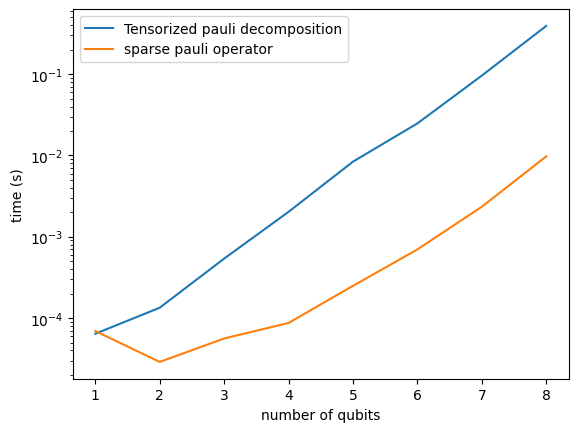

In [15]:
plt.plot(tpdTimes, label = "Tensorized pauli decomposition")
plt.plot(sparsePauliOpTimes, label = "sparse pauli operator")
plt.xlabel("number of qubits")
plt.ylabel("time (s)")
plt.yscale('log')
plt.xticks(np.arange(qubits),np.arange(1,qubits+1))
ax = plt.gca()
plt.legend()

In [16]:
with open('../SimulationResults/resultsLCU.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Number of qubits","Tensorized Pauli Decomposition", "Sparse Pauli Operator"])
    for i in range(qubits):
        writer.writerow([i+1,tpdTimes[i], sparsePauliOpTimes[i]])

In [17]:
classToFilterOut: int = 2
shots: int = 10000
gamma: float = 0.01 # regularization parameter
vqlssvmVectors: VQLSSVM = VQLSSVM(gamma, shots)

In [18]:
tpdTimesOne = []
qubits = 8

for i in range (2,qubits+1):
    xTrain, xTest, yTrain, yTest = prepareDataset(normalizeValues=True, dataset="breastCancer", subsetSize=2**i-1)
    input = LSSVM.lssvmMatrix(xTrain, gamma, "linearKernel")
    print("qubits: ",i)
    testMatrix = input
    start = time.time()
    list1,coeffs1 = tensorizedPauliDecompositionLCU(testMatrix)
    end = time.time()
    tpdTimesOne.append(end-start)
    print(tpdTimesOne[-1])
    print(len(coeffs1))

qubits:  2
0.00047516822814941406
10
qubits:  3
0.0003509521484375
36
qubits:  4
0.0014278888702392578
136
qubits:  5
0.005464076995849609
528
qubits:  6
0.022064924240112305
2080
qubits:  7
0.08727192878723145
8256
qubits:  8
0.3445107936859131
32896


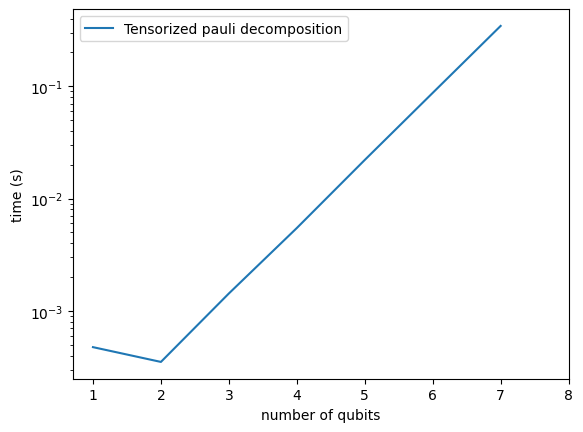

In [22]:
plt.plot(tpdTimesOne, label = "Tensorized pauli decomposition")
plt.xlabel("number of qubits")
plt.ylabel("time (s)")
plt.yscale('log')
plt.xticks(np.arange(qubits),np.arange(1,qubits+1))
ax = plt.gca()
plt.legend()